In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from tensorflow.keras.utils import *
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
from numpy import argmax
import seaborn as sn 

from random import seed
from random import randint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
#X = np.load('../InpactorDB/version_final/InpactorDB_non-redudant.fasta.filtered_zeros.npy').astype(np.int8)
#Y = np.load('../InpactorDB/version_final/InpactorDB_non-redudant.fasta.filtered_zeros_labels.npy').astype(np.int8)

X = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/InpactorDB_non-redundant_final_format_position.npy').astype(np.int8)
Y = np.load('/home/bioml/Projects/PhD/InpactorDB/version_final/InpactorDB_non-redundant_final_format_position_labels.npy').astype(np.int32)

In [4]:
# extract 70k sequences randomly
already = []
X_new = np.zeros((70000, X.shape[1], X.shape[2]), dtype=np.int8)
Y_new = np.zeros((70000, Y.shape[1]), dtype=np.float64)
i = 0
seed(1)
while i < 70000:
    value = randint(0, X.shape[0]-1)
    if value not in already:
        X_new[i] = X[value, :, :]
        Y_new[i, 0] = Y[value, 0]
        Y_new[i, 1] = Y[value, 1]
        i += 1
        
X = X_new
Y = Y_new

In [5]:
print(X.shape)
print(Y.shape)

type(X[0, 0, 0])
print(Y)

(70000, 5, 50000)
(70000, 2)
[[25875. 37483.]
 [    0.     0.]
 [27118. 37023.]
 ...
 [    0.     0.]
 [    0.     0.]
 [25134. 36446.]]


In [6]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

(56000, 5, 50000)
(56000, 2)
(7000, 5, 50000)
(7000, 2)
(7000, 5, 50000)
(7000, 2)


In [7]:
X = None
Y = None
path_log_base = './logs_CNN'

In [8]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [9]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [10]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [11]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=False)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['avg_euclidean_distance']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=False)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Euclidean {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_avg_euclidean_distance']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=False)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation Euclidean {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['avg_euclidean_distance'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_avg_euclidean_distance'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Euclidean Vs Epoch')
        plt.ylabel('Euclidean')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [12]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 60000 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'avg_euclidean_distance':avg_euclidean_distance, 'LeakyReLU': tensorflow.keras.layers.LeakyReLU(alpha=0.1)})
            loss,accuracy = model.evaluate(X_test, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy < B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [13]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_avg_euclidean_distance:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_avg_euclidean_distance', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [14]:
def avg_euclidean_distance(Y_real, Y_predict):
    rest = Y_predict - Y_real
    pow_rest = tf.pow(rest, 2)
    sum_reduced = tf.reduce_sum(pow_rest, 1, keepdims=True)
    result_sqrt = tf.sqrt(sum_reduced)
    result = tf.reduce_mean(result_sqrt)
    return result

In [15]:
def avg_length_diff(Y_real, Y_predict):
    total = 0
    for i in range(Y_real.shape[0]):
        real_len = Y_real[i, 1] - Y_real[i, 0]
        pred_len = Y_predict[i, 1] - Y_predict[i, 0]
        total += abs(real_len - pred_len)
    return total/Y_real.shape[0]

In [16]:
def avg_center_point_diff(Y_real, Y_predict):
    total = 0
    for i in range(Y_real.shape[0]):
        real_center = (Y_real[i, 1] + Y_real[i, 0])/2
        pred_center = (Y_predict[i, 1] + Y_predict[i, 0])/2
        total += abs(real_center - pred_center)
    return total/Y_real.shape[0]

In [17]:
def FPR(Y_real, Y_predict):
    total = 0
    for i in range(Y_real.shape[0]):
        if (Y_real[i, 1] + Y_real[i, 0]) == 0 and (Y_predict[i, 1] + Y_predict[i, 0]) != 0:
            total += 1
    return (total*100)/Y_real.shape[0]

In [18]:
def Experiments():
    tf.keras.backend.clear_session()

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (5, 15), strides=(1,1), activation="relu", use_bias=True)(inputs)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 10), strides= (1, 10))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 2
    layers = tf.keras.layers.Conv2D(128, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 15), strides= (1, 15))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 3
    layers = tf.keras.layers.SeparableConv2D(128, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 15), strides= (1, 15))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(1200,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(layers)
    layers = tf.keras.layers.Dense(1000,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(layers)
    layers = tf.keras.layers.Dense(500,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(2, activation="relu", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.MeanSquaredError()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=[avg_euclidean_distance])
    return model

In [21]:
def INPACTORdet_net():
    """
    Best result:
    
    Baseline Error train: 356.9590759277344
    Baseline Error dev: 758.4258422851562
    Baseline Error test: 697.7144165039062
    
    Length diff Train 296.79971771240236
    Center point diff Train 172.65142049298967
    False Positive Rate Train 0.0017857142857142857
    
    Length diff Dev 435.59133133370534
    Center point diff Dev 429.98894168526783
    False Positive Rate Dev 0.22857142857142856
    
    Length diff Test 431.1202447945731
    Center point diff Test 386.56343486240934
    False Positive Rate Test 0.14285714285714285
    
    """
    tf.keras.backend.clear_session()

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (5, 20), strides=(1,1), activation="relu", use_bias=True)(inputs)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 10), strides= (1, 10))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 2
    layers = tf.keras.layers.Conv2D(128, (1, 20), strides=(1,1), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 15), strides= (1, 15))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 3
    layers = tf.keras.layers.Conv2D(128, (1, 35), strides=(1,1), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((1, 15), strides= (1, 15))(layers)
    #layers = tf.keras.layers.SpatialDropout2D(0.5)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(1200,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(layers)
    layers = tf.keras.layers.Dense(1000,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(layers)
    layers = tf.keras.layers.Dense(500,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(2, activation="relu", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.MeanSquaredError()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=[avg_euclidean_distance])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 50000, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 49986, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 4998, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 4979, 128)      163968    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 331, 128)       0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 1, 297, 128)       20992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 19, 128)        0     

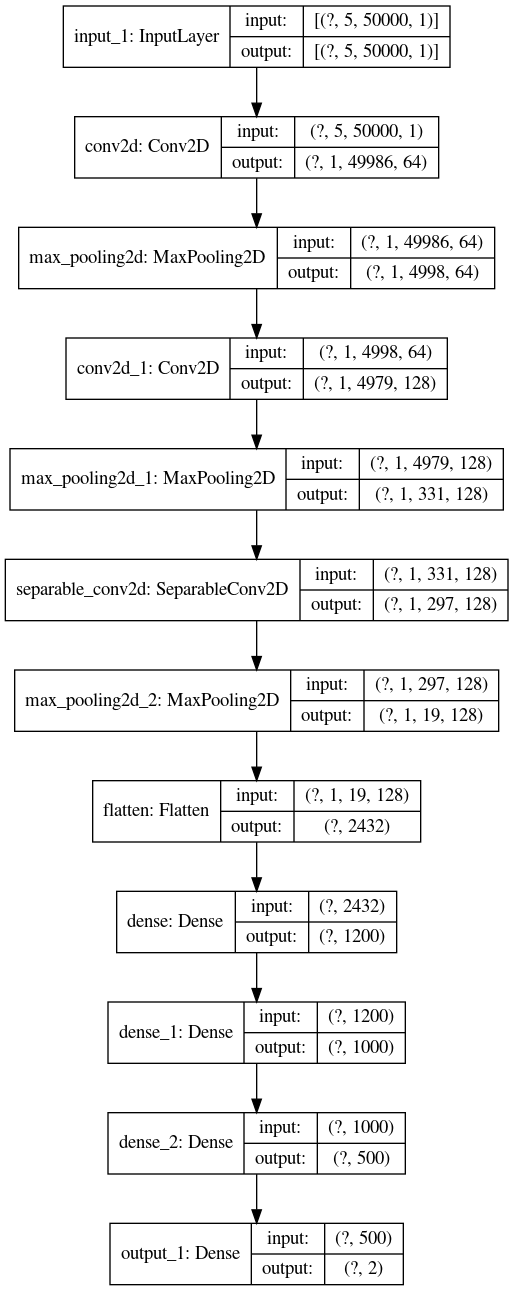

In [19]:
model = Experiments()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
one_hot_labels_train = Y_train#tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = Y_dev#tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = Y_test#tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, 64, epochs, "TERL")
Final_Results_Test(log_Dir) 

Epoch 1/100
875/875 [==============================] - 76s 87ms/step - loss: 290250976.0000 - avg_euclidean_distance: 20234.6602 - val_loss: 227448944.0000 - val_avg_euclidean_distance: 18870.0371
Epoch 2/100
875/875 [==============================] - 76s 87ms/step - loss: 185264880.0000 - avg_euclidean_distance: 16162.9746 - val_loss: 145122640.0000 - val_avg_euclidean_distance: 13760.1260
Epoch 3/100
875/875 [==============================] - 76s 87ms/step - loss: 117414288.0000 - avg_euclidean_distance: 11221.4746 - val_loss: 99390960.0000 - val_avg_euclidean_distance: 9429.9883
Epoch 4/100
875/875 [==============================] - 76s 87ms/step - loss: 69053784.0000 - avg_euclidean_distance: 7236.9326 - val_loss: 62092564.0000 - val_avg_euclidean_distance: 6677.7803
Epoch 5/100
875/875 [==============================] - 76s 87ms/step - loss: 39449692.0000 - avg_euclidean_distance: 4568.4316 - val_loss: 35612732.0000 - val_avg_euclidean_distance: 5133.3340
Epoch 6/100
875/875 [====

Epoch 86/100
875/875 [==============================] - 76s 87ms/step - loss: 1026003.0000 - avg_euclidean_distance: 637.5073 - val_loss: 7958614.0000 - val_avg_euclidean_distance: 1012.9428
Epoch 87/100
875/875 [==============================] - 76s 87ms/step - loss: 1751996.5000 - avg_euclidean_distance: 754.9605 - val_loss: 11882342.0000 - val_avg_euclidean_distance: 1233.8297
Epoch 88/100
875/875 [==============================] - 76s 87ms/step - loss: 1647552.6250 - avg_euclidean_distance: 733.1636 - val_loss: 11404151.0000 - val_avg_euclidean_distance: 1140.3505
Epoch 89/100
875/875 [==============================] - 76s 87ms/step - loss: 950252.9375 - avg_euclidean_distance: 624.6875 - val_loss: 10489776.0000 - val_avg_euclidean_distance: 1261.9432
Epoch 90/100
875/875 [==============================] - 76s 87ms/step - loss: 2024467.5000 - avg_euclidean_distance: 810.7764 - val_loss: 8439772.0000 - val_avg_euclidean_distance: 1013.0285
Epoch 91/100
875/875 [=====================

Loss=7965562.0000 y F1-Score=1093.2744

saved-model-075-1437.4075.hdf5
Loss=10214854.0000 y F1-Score=1426.6675

saved-model-076-1120.2369.hdf5
Loss=8457212.0000 y F1-Score=1043.7250

saved-model-077-1064.9731.hdf5
Loss=8244159.5000 y F1-Score=1006.7183

saved-model-078-991.0385.hdf5
Loss=7285213.5000 y F1-Score=962.4855

saved-model-079-1084.6383.hdf5
Loss=9179039.0000 y F1-Score=1076.5486

saved-model-080-1197.8977.hdf5
Loss=9358468.0000 y F1-Score=1167.7321

saved-model-081-1382.5321.hdf5
Loss=10188537.0000 y F1-Score=1304.0487

saved-model-082-1084.9136.hdf5
Loss=7539561.0000 y F1-Score=1041.4955

saved-model-083-981.0631.hdf5
Loss=8349599.0000 y F1-Score=977.5861

saved-model-084-1143.8469.hdf5
Loss=9033898.0000 y F1-Score=1096.0016

saved-model-085-1239.2914.hdf5
Loss=8471104.0000 y F1-Score=1191.5983

saved-model-086-1012.9428.hdf5
Loss=7169381.5000 y F1-Score=989.7277

saved-model-087-1233.8297.hdf5
Loss=8822524.0000 y F1-Score=1159.6683

saved-model-088-1140.3505.hdf5
Loss=8644

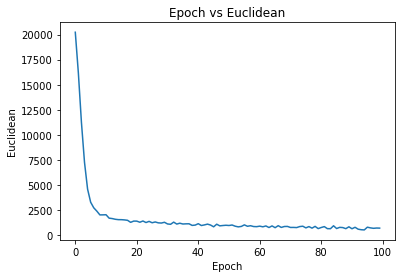

Test F1-Score 889.88818359375, Época:94

Test F1-Score 903.0037231445312, Época:95

Test F1-Score 921.9962158203125, Época:93

Test F1-Score 950.9349975585938, Época:100

Test F1-Score 962.4854736328125, Época:78


Train Euclidean 499.3836669921875, Época:95

Train Euclidean 519.0017700195312, Época:94

Train Euclidean 572.5003662109375, Época:93

Train Euclidean 614.6505737304688, Época:91

Train Euclidean 619.7879028320312, Época:84


Validation Euclidean 961.8926391601562, Época:94

Validation Euclidean 963.8692016601562, Época:95

Validation Euclidean 972.6180419921875, Época:72

Validation Euclidean 981.0631103515625, Época:83

Validation Euclidean 988.9199829101562, Época:93



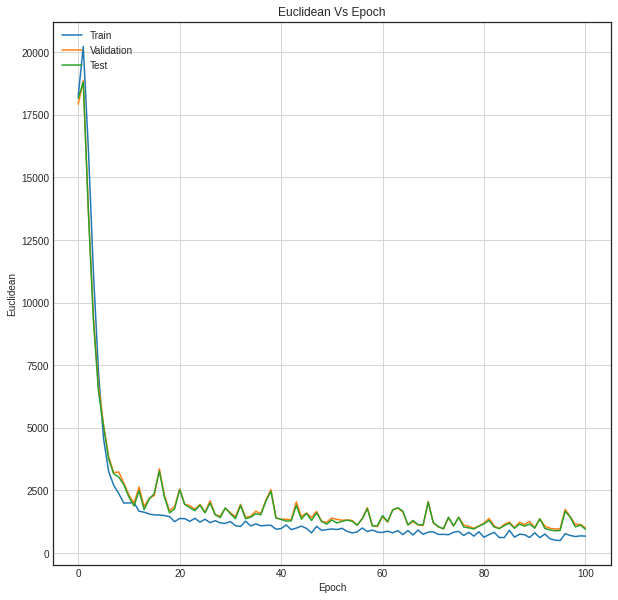

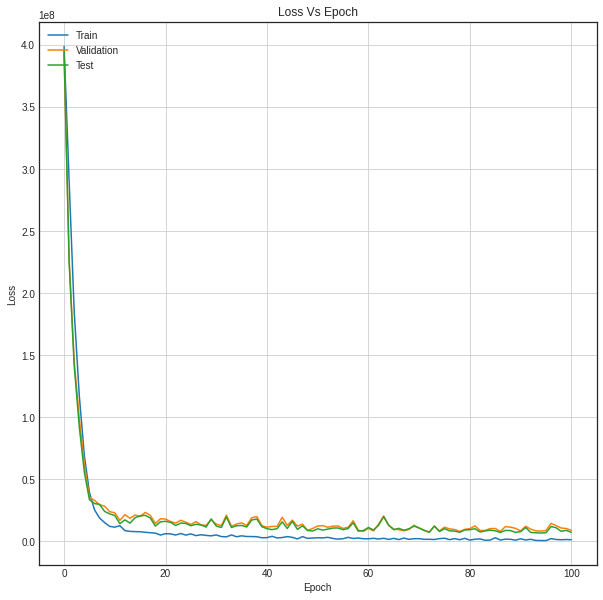

In [21]:
# plot metrics
plt.plot(history.history['avg_euclidean_distance'])
plt.xlabel('Epoch')
plt.ylabel('Euclidean')
plt.title('Epoch vs Euclidean')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


In [23]:
model = tf.keras.models.load_model(log_Dir+'/saved-model-095-755.3814.hdf5', custom_objects={'avg_euclidean_distance':avg_euclidean_distance, 'LeakyReLU': tensorflow.keras.layers.LeakyReLU(alpha=0.1)})
scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: " +str(scores[1]))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: " +str(scores[1]))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: " +str(scores[1]))

predictions = model.predict(X_train)

print("Length diff Train "+ str(avg_length_diff(Y_train, predictions)))
print("Center point diff Train "+ str(avg_center_point_diff(Y_train, predictions)))
print("False Positive Rate Train "+ str(FPR(Y_train, predictions)))

predictions = model.predict(X_dev)

print("Length diff Dev "+ str(avg_length_diff(Y_dev, predictions)))
print("Center point diff Dev "+ str(avg_center_point_diff(Y_dev, predictions)))
print("False Positive Rate Dev "+ str(FPR(Y_dev, predictions)))

predictions = model.predict(X_test)

print("Length diff Test "+ str(avg_length_diff(Y_test, predictions)))
print("Center point diff Test "+ str(avg_center_point_diff(Y_test, predictions)))
print("False Positive Rate Test "+ str(FPR(Y_test, predictions)))


Baseline Error train: 307.31146240234375
Baseline Error dev: 749.3154296875
Baseline Error test: 711.447998046875
Length diff Train 242.78812381853376
Center point diff Train 153.447106338501
False Positive Rate Train 0.005357142857142857
Length diff Dev 395.62522890799386
Center point diff Dev 434.3703218688965
False Positive Rate Dev 0.15714285714285714
Length diff Test 404.81581586129323
Center point diff Test 407.5732097222464
False Positive Rate Test 0.18571428571428572


In [23]:
predictions = model.predict(X_test)
print(predictions[10:20, :])
print(one_hot_labels_test[10:20, :])

[[11730.711 24611.562]
 [    0.        0.   ]
 [21455.854 27419.867]
 [    0.        0.   ]
 [10565.356 17232.754]
 [17821.98  23367.248]
 [    0.        0.   ]
 [17704.775 25411.906]
 [    0.        0.   ]
 [    0.     5172.805]]
[[11481. 24031.]
 [    0.     0.]
 [21013. 27440.]
 [    0.     0.]
 [11664. 16977.]
 [18727. 23660.]
 [    0.     0.]
 [17433. 21970.]
 [    0.     0.]
 [  932.  6384.]]
